In [28]:
import pandas as pd
import re
from sklearn.model_selection import  train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk


In [6]:
df = pd.read_excel(r"A:\University\BSCS 6th sem\NLP\NLP\Dataset_Final.xlsx")
print(df.head(5))

           Drama_Name          dramaname_Ep_#  \
0         Mann Aangan         Mann AanganEp50   
1     Ehsaan Faramosh     Ehsaan FaramoshEp54   
2              Hasrat              HasratEp17   
3  Bandhay Ek Dour Se  Bandhay Ek Dour SeEp12   
4         Mann Aangan          Mann AanganEp7   

                                           Url timestamp(start-time)  \
0  https://www.youtube.com/watch?v=_IWRO3WUwF4              21:14:00   
1  https://www.youtube.com/watch?v=3Unh9qXQVM0       1 day, 11:32:00   
2  https://www.youtube.com/watch?v=gjN0C7utxdQ        1 day, 0:41:00   
3  https://www.youtube.com/watch?v=UrRnFjTGx5M              16:04:00   
4  https://www.youtube.com/watch?v=6KmjgxAduAc       1 day, 13:36:00   

  timestamp(end-time)  Sentence_No  \
0               21:19          123   
1            35:35:00          343   
2            24:44:00          283   
3               16:08          223   
4            37:40:00          381   

                                  Urdu_Sent

In [9]:
def urdu_preprocessor(text):
    text = re.sub(r'[۔،؛؟!٭ء]', ' ', str(text))  # Remove Urdu punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    try:
        tokens = word_tokenize(text)
        urdu_stopwords = set(stopwords.words('urdu')) if 'urdu' in stopwords.fileids() else set()
        tokens = [token for token in tokens if token not in urdu_stopwords]
        return ' '.join(tokens)
    except Exception as e:
        return text

# Clean text
df['cleaned_text'] = df['Urdu_Sentence_text'].apply(urdu_preprocessor)
print(df['cleaned_text'].head(5))

0              میں نے رامشا کو کبھی اتنا ضد نہیں دیکھا
1                          وہ لوگ جن کے اچھے ارادے ہیں
2    جب آپ مجھ پر اعتماد نہیں کرتے ہیں تو پھر اس کا...
3                 اور آپ اس کے بارے میں غمگین رہتے تھے
4    لیکن مجھے کوئی اندازہ نہیں تھا کہ آپ اس طرح کا...
Name: cleaned_text, dtype: object


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['Sentiment(P/N)'],
    test_size=0.2,
    random_state=42,
    stratify=df['Sentiment(P/N)']
)

In [11]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.7
    )),
    ('classifier', MultinomialNB())
])

In [12]:
# Train model
print("Training model...")
pipeline.fit(X_train, y_train)

Training model...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=10000, min_df=5,
                                 ngram_range=(1, 2))),
                ('classifier', MultinomialNB())])


Accuracy: 0.8969

Classification Report:
              precision    recall  f1-score   support

           N       0.88      0.92      0.90      4000
           P       0.91      0.88      0.89      3895

    accuracy                           0.90      7895
   macro avg       0.90      0.90      0.90      7895
weighted avg       0.90      0.90      0.90      7895



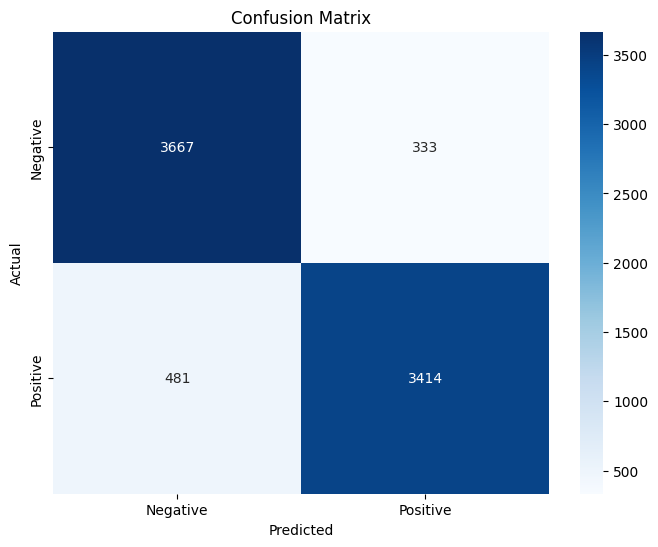

In [16]:
# 6. Evaluate Model
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")  # Prints accuracy with 4 decimal places

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Save components
joblib.dump(pipeline.named_steps['tfidf'], 'urdu_tfidf_vectorizer.pkl')
joblib.dump(pipeline.named_steps['classifier'], 'urdu_sentiment_nb_classifier.pkl')

print("\n✅ Naive Bayes model training complete!")
print("Saved: urdu_tfidf_vectorizer.pkl")
print("Saved: urdu_sentiment_nb_classifier.pkl")


✅ Naive Bayes model training complete!
Saved: urdu_tfidf_vectorizer.pkl
Saved: urdu_sentiment_nb_classifier.pkl


In [29]:
# Load components
vectorizer = joblib.load('urdu_tfidf_vectorizer.pkl')
model = joblib.load('urdu_sentiment_nb_classifier.pkl')

# Define common Urdu negation terms
urdu_negations = {
    "نہیں", "نہ", "مت", "ہرگز نہیں", "کبھی نہیں", "بالکل نہیں", 
    "انکار", "ممنوع", "ناممکن", "غلط", "اجتناب", "عدم", "نا", 
    "بے", "خلاف", "ممنوعہ", "رد", "منع", "منکر", "محروم", 
    "مسترد", "نفی", "محفوظ نہیں", "غیر"
}


# Prediction function with negation-based label flipping
def predict_sentiment(text):
    cleaned = urdu_preprocessor(text)
    features = vectorizer.transform([cleaned])
    prediction = model.predict(features)[0]
    
    # Check for negation in original text (not cleaned)
    if any(neg in text for neg in urdu_negations):
        prediction = 'N' if prediction == 'P' else 'P'
    
    return prediction

def is_urdu(text):
    # Check if all characters are within Urdu Unicode range (including spaces, punctuation)
    urdu_regex = re.compile(r'^[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s.,!؟؛،۔]+$')
    return bool(urdu_regex.fullmatch(text))

# Test case
# test_urdu = "یہ فلم بہت بری نہیں تھی"
# test_urdu = "یہ فلم بہت اچہی تھی"
print("Enter the Urdu sentence for prediction: ")
test_urdu = input()

if not is_urdu(test_urdu):
    print("Error: Input must be in Urdu only (no English words/numbers).")
else:
    print(f"Test Sentence: {test_urdu}")
    print("Predicted Sentiment:", predict_sentiment(test_urdu))


Enter the Urdu sentence for prediction: 
Test Sentence: سیکھ رہا ہوں اور یہ بہت دلچسپ ہے
Predicted Sentiment: P
